In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import functions as f

In [4]:
import soilconctomcnp as sm

In [5]:
mass_functions = pd.read_pickle('data/massfunctions.pkl')

In [6]:
mass_functions

,combo_id,combo,carbon_func,nitrogen_func,carbon_params,nitrogen_params
0,0,const,<function const at 0x7a365f624310>,<function const at 0x7a365f624310>,[0.004992609570236395],[0.004992609570236395]
1,1,linear,<function linear at 0x7a365f6243a0>,<function linear at 0x7a365f6243a0>,"[0.00019862192575141282, 0.007971863609826437]","[0.00019862192575141282, 0.007971863609826437]"
2,2,plane,<function plane at 0x7a360d737010>,<function plane at 0x7a360d737010>,"[1.5303714398684165e-08, 9.667953700526266e-11...","[1.5303714398684165e-08, 9.667953700526266e-11..."
3,3,quad,<function quad at 0x7a360d7370a0>,<function quad at 0x7a360d7370a0>,"[-4.1382608135894603e-13, 3.689119991081925e-1...","[-4.1382608135894603e-13, 3.689119991081925e-1..."
4,4,quad_plane,<function quad_plane at 0x7a360d737130>,<function quad_plane at 0x7a360d737130>,"[-1.8475158769238626e-13, 3.738134677365824e-1...","[-1.8475158769238626e-13, 3.738134677365824e-1..."


# Deciding Path

In [7]:
# read json file 'data/feild_info.json' and store it in a variable called 'field_info'
import json
with open('data/field_info.json') as f:
    field_info = json.load(f)


In [8]:
fence = np.array(field_info['corners'])

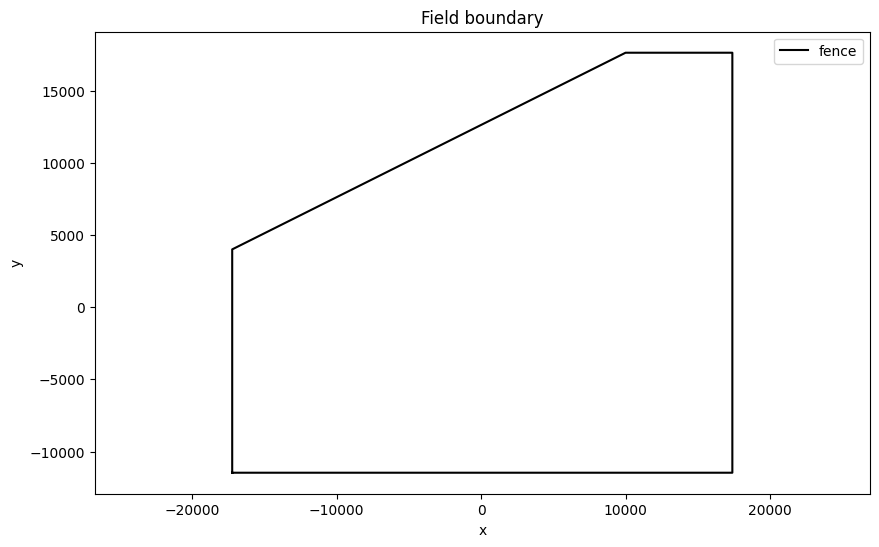

In [9]:

plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary')
plt.axis('equal')
plt.show()


In [10]:
fence[-2]

array([-17238.30257494,   4000.        ])

dis_between_points: 5507.504425053346 cm


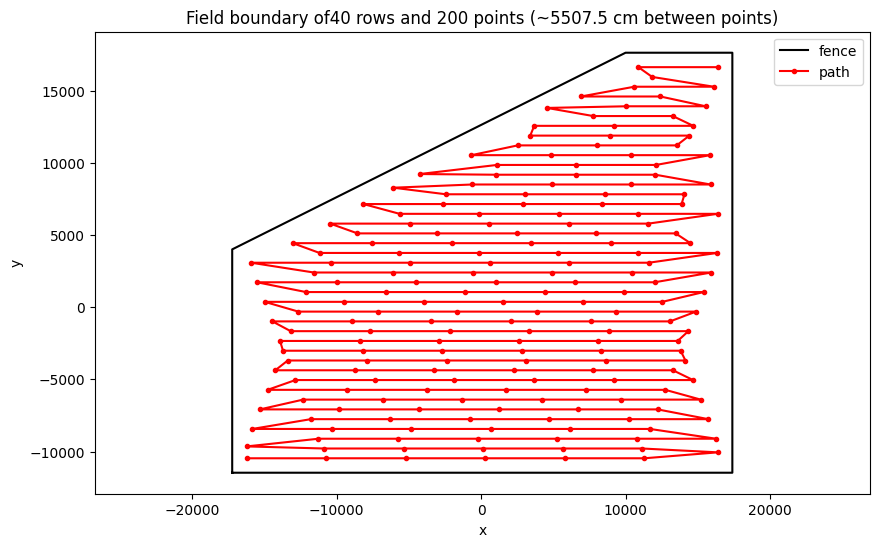

In [11]:
from scipy.interpolate import interp1d

bot_x = fence[0][0]+1000
top_x = fence[1][0]-1000
bot_y = fence[0][1]+1000
top_y = fence[2][1]-1000

a = (fence[-2][0]+1000, fence[-2][1]-1000)
b = (fence[-3][0], fence[-3][1]-1000)

rows = 40

n_points_on_path = 200

path = [
    (bot_x,bot_y),
    (top_x,bot_y),
]

for i in range(1,rows+1):
    if i%2 == 1:
        path.append((top_x,bot_y+i*(top_y-bot_y)/rows))
        _x = bot_x
        _y = bot_y+i*(top_y-bot_y)/rows
        if _y > a[1]:
            _x = ((b[0]-a[0])/(b[1]-a[1]))*(_y-a[1])+a[0]

        path.append((_x,bot_y+i*(top_y-bot_y)/rows))
    else:
        _x = bot_x
        _y = bot_y+i*(top_y-bot_y)/rows
        if _y > a[1]:
            _x = ((b[0]-a[0])/(b[1]-a[1]))*(_y-a[1])+a[0]
        path.append((_x,bot_y+i*(top_y-bot_y)/rows))
        path.append((top_x,bot_y+i*(top_y-bot_y)/rows))

path = np.array(path)

# linspace on path without functions.py
# Calculate cumulative distance along the path
distances = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

# Interpolate to get evenly spaced points
interp_func = interp1d(cumulative_distances, path, axis=0, kind='linear')
evenly_spaced_distances = np.linspace(0, cumulative_distances[-1], n_points_on_path)
dis_between_points = np.diff(evenly_spaced_distances)[0]
print('dis_between_points:', dis_between_points, 'cm')
path = interp_func(evenly_spaced_distances)

plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.plot(path[:, 0], path[:, 1], 'r-', label='path', marker='.')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary of'+str(rows)+' rows and '+str(n_points_on_path)+' points (~'+str(round(dis_between_points,1))+' cm between points)')
plt.axis('equal')
plt.show()

# Generating Sections

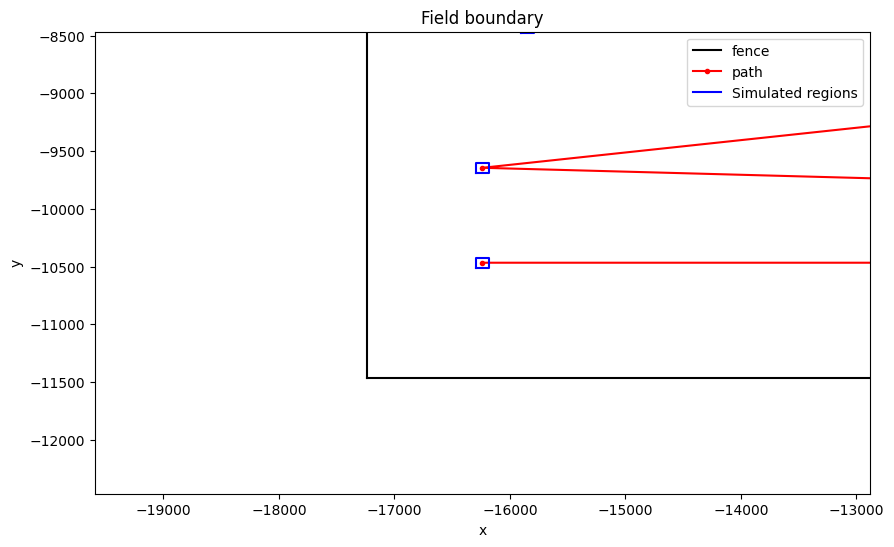

In [12]:
# in mcnp the soil surface is defined by 1 rpp -56 56 -45 45 42 92 $Soil xmin xmax ymin ymax zmin zmax
x_pad = 56
y_pad = 45
z_pad = 92-42

# draw a rectangle around each point in the path
plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.plot(path[:, 0], path[:, 1], 'r-', label='path', marker='.')
for point in path[:-1]:
    plt.plot([point[0]-x_pad, point[0]+x_pad, point[0]+x_pad, point[0]-x_pad, point[0]-x_pad],
             [point[1]-y_pad, point[1]-y_pad, point[1]+y_pad, point[1]+y_pad, point[1]-y_pad],
             'b-')
point = path[-1]
plt.plot([point[0]-x_pad, point[0]+x_pad, point[0]+x_pad, point[0]-x_pad, point[0]-x_pad],
         [point[1]-y_pad, point[1]-y_pad, point[1]+y_pad, point[1]+y_pad, point[1]-y_pad],
         'b-', label='Simulated regions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary')
plt.axis('equal')
plt.xlim(fence[0][0]-1000, (path[0][0]-(fence[0][0]-1000))+path[0][0])
plt.ylim(fence[0][1]-1000, (path[0][1]-(fence[0][1]-1000))+path[0][1])
plt.show()

# Generating subections

In [13]:
mass_functions

,combo_id,combo,carbon_func,nitrogen_func,carbon_params,nitrogen_params
0,0,const,<function const at 0x7a365f624310>,<function const at 0x7a365f624310>,[0.004992609570236395],[0.004992609570236395]
1,1,linear,<function linear at 0x7a365f6243a0>,<function linear at 0x7a365f6243a0>,"[0.00019862192575141282, 0.007971863609826437]","[0.00019862192575141282, 0.007971863609826437]"
2,2,plane,<function plane at 0x7a360d737010>,<function plane at 0x7a360d737010>,"[1.5303714398684165e-08, 9.667953700526266e-11...","[1.5303714398684165e-08, 9.667953700526266e-11..."
3,3,quad,<function quad at 0x7a360d7370a0>,<function quad at 0x7a360d7370a0>,"[-4.1382608135894603e-13, 3.689119991081925e-1...","[-4.1382608135894603e-13, 3.689119991081925e-1..."
4,4,quad_plane,<function quad_plane at 0x7a360d737130>,<function quad_plane at 0x7a360d737130>,"[-1.8475158769238626e-13, 3.738134677365824e-1...","[-1.8475158769238626e-13, 3.738134677365824e-1..."


In [14]:
i = 4
j = 0
element = 'nitrogen'


row = mass_functions.iloc[i]
mass_function_params = row[element+'_params']
mass_function_name = row['combo']
_mass_function = row[element+'_func']
mass_function = lambda x_val: _mass_function(x_val, *(mass_function_params))
point = path[j]
x, y = point
soil_z0 = -z_pad
soil_z1 = 0
soil_x0 = x-x_pad
soil_x1 = x+x_pad
soil_y0 = y-y_pad
soil_y1 = y+y_pad

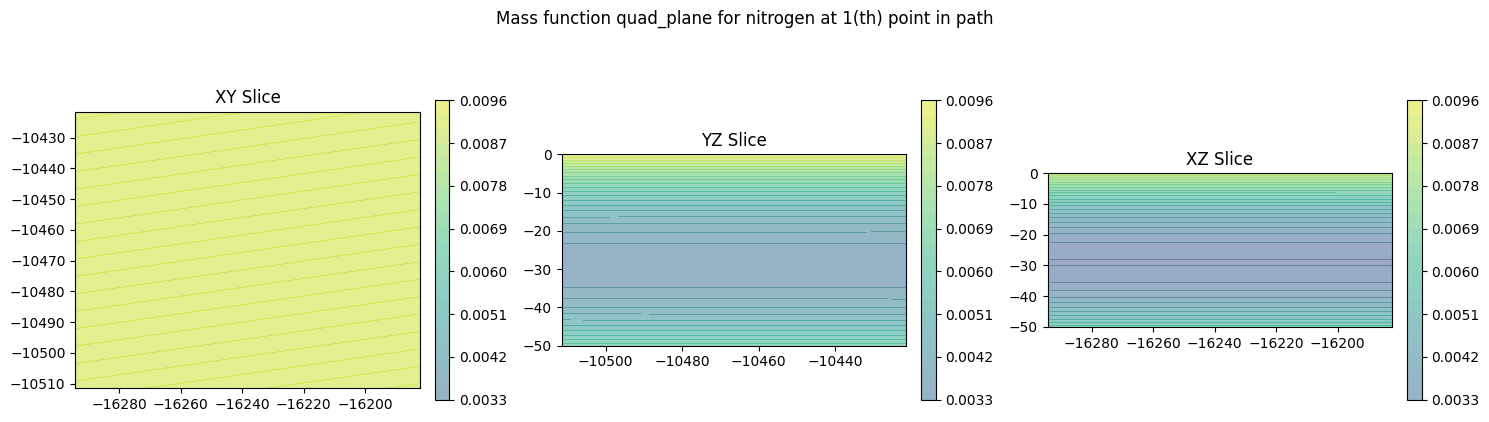

In [15]:
v_min = 0
v_max = .01

fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
xy_contf, xy_conc = sm.xy_slice_inspect(axs[0], mass_function, soil_x0, soil_x1, soil_y0, soil_y1, soil_z1, 100, v_min, v_max)
axs[0].set_title('XY Slice')
yz_contf, yz_conc = sm.yz_slice_inspect(axs[1], mass_function, soil_y0, soil_y1, soil_z0, soil_z1, 0, 100, v_min, v_max)
axs[1].set_title('YZ Slice')
xz_contf, xz_conc = sm.xz_slice_inspect(axs[2], mass_function, soil_x0, soil_x1, soil_z0, soil_z1, 0, 100, v_min, v_max)
axs[2].set_title('XZ Slice')

contfs = [xy_contf, yz_contf, xz_contf]
for ax in axs:
    fig.colorbar(contfs[1], ax=ax, fraction=0.04, pad=0.04, boundaries=np.linspace(v_min, v_max, 100))
plt.tight_layout()
plt.suptitle('Mass function '+mass_function_name+' for '+element+' at '+str(j+1)+'(th) point in path')
plt.show()

In [16]:
carbon_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['carbon_func'](x_val, *mass_functions.iloc[i]['carbon_params']), 0, 1)
nitrogen_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['nitrogen_func'](x_val, *mass_functions.iloc[i]['nitrogen_params']), 0, 1)
silicone_mass_function = lambda x_val: 1-carbon_mass_function(x_val)-nitrogen_mass_function(x_val)

f = lambda x_val: np.column_stack([carbon_mass_function(x_val), nitrogen_mass_function(x_val), silicone_mass_function(x_val)])

In [17]:
extent = [soil_x0, soil_x1, soil_y0, soil_y1, soil_z0, soil_z1]
res = (10, 10, 10)
sides = sm.cut_bounds(extent, res)
_, midpoints = sm.get_midpoints(sides, res, extent)

In [18]:
f(midpoints).shape

(1000, 3)

In [19]:

_x_pad = (soil_x1-soil_x0)/res[0]
_y_pad = (soil_y1-soil_y0)/res[1]
_z_pad = (soil_z1-soil_z0)/res[2]
pad = (_x_pad, _y_pad, _z_pad)
elems = sm.sample_section(f, midpoints, pad, 50)

In [20]:
elem_names = ['carbon', 'nitrogen', 'silicone']
elem_labels = ['6000', '7000', '14000']

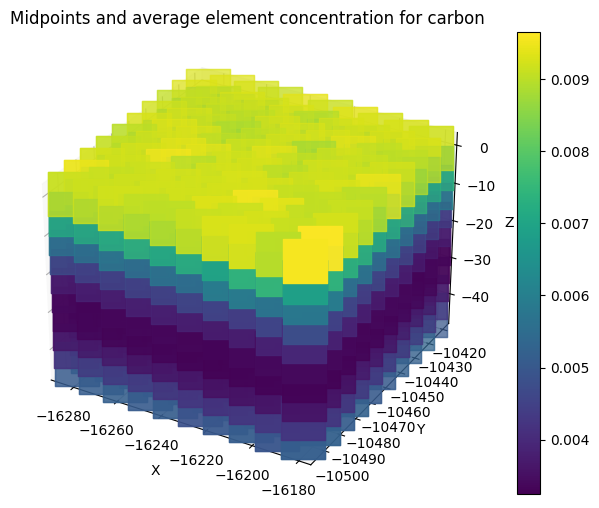

In [21]:
# 3d graph of midpoints and elems
lm = 0
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], c=elems[:, lm], cmap='viridis', s=1000
           , marker='s'
           )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Midpoints and average element concentration for '+elem_names[lm])
plt.colorbar(ax.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], c=elems[:, lm], cmap='viridis', s=1000
           , marker='s'
           ))
plt.show()

# Generating MCNP input

In [22]:
cells, walls, surfaces, mats = sm.make_mcnp(
    f,
    extent,
    res,
    elem_labels,
    density = -2.156,
    x_fix=x,
    y_fix=y,
    z_fix=42,
    z_mul=-1,
    surface_header='200',
    cell_header='300',
    mat_header='400',
)

In [23]:
walls


('200100', '200110', '200200', '200210', '200300', '200310')

In [24]:
mcnp_code_start = """c CAS DETECTOR
c w/ Shielding in Place and Wheels
c
c CELL CARDS
c
c @@@@@@@@@@ Detectors @@@@@@@@@@@@@@@@@
c
101 8 -5.08 -21 imp:n,p 1 $LaBr Detector #1 Active Region
c
c @@@@@@@@@ Shielding @@@@@@@@@@@@@@@@@
c
121 2 -4.78 -31 imp:n,p 1 $PE_Pb
122 4 -11.29 -32 imp:n,p 1 $Pb1
123 4 -11.29 -33 imp:n,p 1 $Pb2
124 4 -11.29 -34 imp:n,p 1 $Pb3
125 4 -11.29 -35 imp:n,p 1 $Pb4
126 4 -11.29 -36 imp:n,p 1 $Pb5
127 4 -11.29 -37 imp:n,p 1 $Pb6
128 3 -1.5 -38 imp:n,p 1 $BA1
129 3 -1.5 -39 imp:n,p 1 $BA2
130 6 -2.7 -40 imp:n,p 1 $Al
131 7 -7.92 301 -302 303 -304 imp:n,p 1 $Fe-tube
132 5 -7.8 -401 imp:n,p 1 $Fe
133 5 -7.8 -402 imp:n,p 1 $Fe
c @@@@@@@@@@ Wheels @@@@@@@@@@@@@@@@@
c
21 13 -0.92 -41 42 imp:n,p 1 $Wheel 1
211 13 -0.92 -421 422 imp:n,p 1 $Wheel 1
212 13 -0.92 -423 424 imp:n,p 1 $Wheel 1
22 13 -0.92 -43 44 imp:n,p 1 $Wheel 2
221 13 -0.92 -441 442 imp:n,p 1 $Wheel 2
222 13 -0.92 -443 444 imp:n,p 1 $Wheel 2
23 13 -0.92 -45 46 imp:n,p 1 $Wheel 3
231 13 -0.92 -461 462 imp:n,p 1 $Wheel 3
232 13 -0.92 -463 464 imp:n,p 1 $Wheel 3
24 13 -0.92 -47 48 imp:n,p 1 $Wheel 4
241 13 -0.92 -481 482 imp:n,p 1 $Wheel 4
242 13 -0.92 -483 484 imp:n,p 1 $Wheel 4
c
c @@@@@@@@@@ SOIL VOLUME @@@@@@@@@@@
c
"""
post_cells = """c
30 12 -0.00129 -200 #101 #121 #122 #123 #124 #125 #126 #127 #128 #129 #130 #131 #132 #133
        #21 #211 #212 #22 #221 #222 #23 #231 #232 #24 #241 #242"""  

post_walls = """ imp:n,p 1 $Rest of the World
31 0 200 imp:n,p 0 $Outside world

c SURFACE CARDS
c
c Sample Volume
"""

post_surfaces = """c Active Detector Region
21 rcc 56  -5.0 -1.0   0.0 20.3 0.0   4.5 $Detector 1 Base center, Hx,Hy,Hz, radius
c Shielding Surfaces
c Shielding Pb
31 rpp 19 29 -7.5 7.5 -11 9 $PbPE xmin xmax ymin ymax zmin zmax
32 rpp 9 19 4 9 -11 9 $Pb xmin xmax ymin ymax zmin zmax
33 rpp 9 19 -9 -4 -11 9 $Pb xmin xmax ymin ymax zmin zmax
34 rpp 19 29 7.5 12.5 -11 9 $Pb xmin xmax ymin ymax zmin zmax
35 rpp 19 29 -12.5 -7.5 -11 9 $Pb xmin xmax ymin ymax zmin zmax
36 rpp 29 34 -15 15 -11 9 $Pb xmin xmax ymin ymax zmin zmax
37 rpp 9 19 -4 4 4 9 $Pb xmin xmax ymin ymax zmin zmax
38 rpp -26 26 18 28 -11 9 $BA1 xmin xmax ymin ymax zmin zmax
39 rpp -26 26 -28 -18 -11 9 $BA2 xmin xmax ymin ymax zmin zmax
40 rpp -65 65 -28 28 10 10.5 $Al xmin xmax ymin ymax zmin zmax
401 rpp -27 27 29 34 -11 9 $Fe xmin xmax ymin ymax zmin zmax
402 rpp -27 27 -34 -29 -11 9 $Fe xmin xmax ymin ymax zmin zmax
301 px -20
302 px 18
303 cx 3.71
304 cx 3.81
c Wheels Surfaces
c 23/10.5-12 turf tires, 22.6 lb rubber
c diameter 29cm, tread width 25cm, and sidewall height 13.76 cm
c set thickness of all sides 1.3 cm (s.t. weight is 22.6 lb)
41 rcc -2 77 8   0.0 25 0.0 29 $wheel 1 outer tread surface
42 rcc -2 77 8   0.0 25 0.0 27.7 $wheel 1 inner tread surface
421 rcc -2 75.7 8   0.0 1.3 0.0 29 $wheel 1 outside sidewall exterior
422 rcc -2 75.7 8   0.0 1.3 0.0 15.24 $wheel 1 outside sidewall interior
423 rcc -2 102 8   0.0 1.3 0.0 29 $wheel 1 inside sidewall exterior
424 rcc -2 102 8   0.0 1.3 0.0 15.24 $wheel 1 inside sidewall interior
43 rcc 68 77 8   0.0 25 0.0 29 $wheel 2
44 rcc 68 77 8   0.0 25 0.0 27.7
441 rcc 68 75.7 8   0.0 1.3 0.0 29
442 rcc 68 75.7 8   0.0 1.3 0.0 15.24
443 rcc 68 102 8   0.0 1.3 0.0 29
444 rcc 68 102 8   0.0 1.3 0.0 15.24
45 rcc -2 -77 8   0.0 -25 0.0 29 $wheel 3
46 rcc -2 -77 8   0.0 -25 0.0 27.7
461 rcc -2 -75.7 8   0.0 -1.3 0.0 29
462 rcc -2 -75.7 8   0.0 -1.3 0.0 15.24
463 rcc -2 -102 8   0.0 -1.3 0.0 29
464 rcc -2 -102 8   0.0 -1.3 0.0 15.24
47 rcc 68 -77 8   0.0 -25 0.0 29 $wheel 4
48 rcc 68 -77 8   0.0 -25 0.0 27.7
481 rcc 68 -75.7 8   0.0 -1.3 0.0 29
482 rcc 68 -75.7 8   0.0 -1.3 0.0 15.24
483 rcc 68 -102 8   0.0 -1.3 0.0 29
484 rcc 68 -102 8   0.0 -1.3 0.0 15.24
200 so 800    $sphere of 800cm centered at origin
c

"""

data_card = """c DATA CARDS
mode n p
c dump every hr
prdmp -60 -60 -1
c 100 keV Neutron Energy Cutoff
Cut:n 1j 0.1
c analog neutron transport
phys:n 1j 14
phys:p
sdef pos=0 0 0 erg=14.0 vec= 0 0 1 dir=d1
si1  -1 .93 1
sp1   0  0.0  1.0
c ********************
c begin material cards
c ********************
c Pure Carbon
c ****************************************
"""

post_mats = """c **********************************
c PE+Pb, dens=4.78 g/cm3
m2      6000    -0.04286 $Carbon
        1001    -0.00714 $Hydrogen
        82000   -0.95000 $Lead
c **********************************
m3    1001 -0.048535 $Boric acid
      5010 -0.034981
      5011 -0.139923
      8016 -0.776561
c **********************************
m4    82000 1 $Lead
c **********************************
m5 26000 1 $Iron
c **********************************
m6     13027   -1.000 $ Aluminum
c **********************************
c  SS-304 (8.00 g/cm3), #298 in PNNL Compendium
m7   006000.50c -0.0004000
     014000.60c -0.0050000
     015031.50c -0.0002300
     016000.60c -0.0001500
     024000.50c -0.1899981
     025055.60c -0.0099999
     026000.50c -0.7017229
     028000.50c -0.0924991
c ****************************************
c       LaBr detector
c ****************************************
m8       35079    -0.2946       $ Br79
         35081    -0.3069       $ Br81
         57139    -0.3485       $ La139
         58140    -0.0500       $ Ce140
c ************ air den=1.15e-3g/cc
m12     8016 -0.23
        7014 -0.77
c ************ Rubber Natural den=0.92 g/cc
m13     1001 -0.118371  $weight fraction
        6000 -0.881629
c
c end material cards
c
rand seed=8674536546524321 $different initial random #; seed# - any less 18 digits
c
c ********** begin tallies *********************
fc78 *********Broadened Pulse Height Tally Sum of Detectors 1,2 & 3 ***********
e78 0 1e-5 932i 8.4295
F78:p (101)
FT78 GEB -0.026198 0.059551 -0.037176
fc18 *********Unbroadened Pulse Height Tally Sum of Detectors 1,2 & 3 ***********
e18 0 1e-5 932i 8.4295
F18:p (101)
c ***********************************
c mplot tal 78 freq 10000
nps 1e9
"""

In [25]:
z_mul = -1
mcnpgen = lambda cells, walls, surfaces, mats: mcnp_code_start+cells+post_cells+" #("+str(walls[0])+" -"+str(walls[1])+" "+str(walls[2])+" -"+str(walls[3])+" "+str(z_mul*int(walls[4]))+" "+str(z_mul*-int(walls[5]))+")"+post_walls+surfaces+post_surfaces+data_card+mats+post_mats

In [26]:
print(mcnpgen(cells, walls, surfaces, mats))

c CAS DETECTOR
c w/ Shielding in Place and Wheels
c
c CELL CARDS
c
c @@@@@@@@@@ Detectors @@@@@@@@@@@@@@@@@
c
101 8 -5.08 -21 imp:n,p 1 $LaBr Detector #1 Active Region
c
c @@@@@@@@@ Shielding @@@@@@@@@@@@@@@@@
c
121 2 -4.78 -31 imp:n,p 1 $PE_Pb
122 4 -11.29 -32 imp:n,p 1 $Pb1
123 4 -11.29 -33 imp:n,p 1 $Pb2
124 4 -11.29 -34 imp:n,p 1 $Pb3
125 4 -11.29 -35 imp:n,p 1 $Pb4
126 4 -11.29 -36 imp:n,p 1 $Pb5
127 4 -11.29 -37 imp:n,p 1 $Pb6
128 3 -1.5 -38 imp:n,p 1 $BA1
129 3 -1.5 -39 imp:n,p 1 $BA2
130 6 -2.7 -40 imp:n,p 1 $Al
131 7 -7.92 301 -302 303 -304 imp:n,p 1 $Fe-tube
132 5 -7.8 -401 imp:n,p 1 $Fe
133 5 -7.8 -402 imp:n,p 1 $Fe
c @@@@@@@@@@ Wheels @@@@@@@@@@@@@@@@@
c
21 13 -0.92 -41 42 imp:n,p 1 $Wheel 1
211 13 -0.92 -421 422 imp:n,p 1 $Wheel 1
212 13 -0.92 -423 424 imp:n,p 1 $Wheel 1
22 13 -0.92 -43 44 imp:n,p 1 $Wheel 2
221 13 -0.92 -441 442 imp:n,p 1 $Wheel 2
222 13 -0.92 -443 444 imp:n,p 1 $Wheel 2
23 13 -0.92 -45 46 imp:n,p 1 $Wheel 3
231 13 -0.92 -461 462 imp:n,p 1 $Wheel 3
232 13

In [27]:
mass_functions

,combo_id,combo,carbon_func,nitrogen_func,carbon_params,nitrogen_params
0,0,const,<function const at 0x7a365f624310>,<function const at 0x7a365f624310>,[0.004992609570236395],[0.004992609570236395]
1,1,linear,<function linear at 0x7a365f6243a0>,<function linear at 0x7a365f6243a0>,"[0.00019862192575141282, 0.007971863609826437]","[0.00019862192575141282, 0.007971863609826437]"
2,2,plane,<function plane at 0x7a360d737010>,<function plane at 0x7a360d737010>,"[1.5303714398684165e-08, 9.667953700526266e-11...","[1.5303714398684165e-08, 9.667953700526266e-11..."
3,3,quad,<function quad at 0x7a360d7370a0>,<function quad at 0x7a360d7370a0>,"[-4.1382608135894603e-13, 3.689119991081925e-1...","[-4.1382608135894603e-13, 3.689119991081925e-1..."
4,4,quad_plane,<function quad_plane at 0x7a360d737130>,<function quad_plane at 0x7a360d737130>,"[-1.8475158769238626e-13, 3.738134677365824e-1...","[-1.8475158769238626e-13, 3.738134677365824e-1..."


In [28]:
np.random.seed(1337)
filenames = []
file_ids = []
function_names = []

x_pad = 56
y_pad = 45
z_pad = 92-42

res = (10, 10, 10)

elem_names = ['carbon', 'nitrogen', 'silicone']
elem_labels = ['6000', '7014', '14000']

x_points = []
y_points = []

for i in range(len(mass_functions)):
    for j in range(len(path)):
        row = mass_functions.iloc[i]
        carbon_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['carbon_func'](x_val, *mass_functions.iloc[i]['carbon_params']), 0, 1)
        nitrogen_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['nitrogen_func'](x_val, *mass_functions.iloc[i]['nitrogen_params']), 0, 1)
        silicone_mass_function = lambda x_val: 1-carbon_mass_function(x_val)-nitrogen_mass_function(x_val)

        f = lambda x_val: np.column_stack([carbon_mass_function(x_val), nitrogen_mass_function(x_val), silicone_mass_function(x_val)])

        point = path[j]
        x, y = point
        soil_z0 = -z_pad
        soil_z1 = 0
        soil_x0 = x-x_pad
        soil_x1 = x+x_pad
        soil_y0 = y-y_pad
        soil_y1 = y+y_pad
        extent = [soil_x0, soil_x1, soil_y0, soil_y1, soil_z0, soil_z1]

        cells, walls, surfaces, mats = sm.make_mcnp(
            f,
            extent,
            res,
            elem_labels,
            density = -2.156,
            x_fix=x,
            y_fix=y,
            z_fix=-42,
            z_mul=-1,
            surface_header='200',
            cell_header='300',
            mat_header='400',
        )

        file_id = str(i)+'_'+str(j)
        filename = 'mcnp_sims/field/compute/input/'+file_id+'.txt'
        with open(filename, 'w') as f:
            f.write(mcnpgen(cells, walls, surfaces, mats))
        filenames.append(filename)
        file_ids.append(file_id)
        function_names.append(row['combo'])
        x_points.append(x)
        y_points.append(y)

filenames = pd.DataFrame({'filename': filenames, 'file_id': file_ids, 'function_name': function_names, 'x': x_points, 'y': y_points})
filenames.to_csv('mcnp_sims/field/filenames.csv', index=False)

In [31]:
filenames

,filename,file_id,function_name,x,y
0,mcnp_sims/field/compute/input/0_0.txt,0_0,const,-16238.302575,-10466.546735
1,mcnp_sims/field/compute/input/0_1.txt,0_1,const,-10730.798150,-10466.546735
2,mcnp_sims/field/compute/input/0_2.txt,0_2,const,-5223.293725,-10466.546735
3,mcnp_sims/field/compute/input/0_3.txt,0_3,const,284.210700,-10466.546735
4,mcnp_sims/field/compute/input/0_4.txt,0_4,const,5791.715125,-10466.546735
...,...,...,...,...,...
995,mcnp_sims/field/compute/input/4_195.txt,4_195,quad_plane,10608.904352,15263.462581
996,mcnp_sims/field/compute/input/4_196.txt,4_196,quad_plane,16116.408777,15263.462581
997,mcnp_sims/field/compute/input/4_197.txt,4_197,quad_plane,11844.726799,15940.568089
998,mcnp_sims/field/compute/input/4_198.txt,4_198,quad_plane,10888.262822,16617.673598


In [32]:
positions = filenames[['x', 'y']]
positions.to_csv('data/positions.csv', index=False)